# Peak and tilt determination by fitting Lorentzians to projections

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import xrayutilities as xu
import h5py
import lib.calc as calc
import lib.plot_mpl as plot
from imp import reload
import matplotlib as mpl

Way to do this: select a roi using the `viewer.py` script. Remember that the stitched and gridded scans are stored in `E16014_stitch.h5`. 

In [5]:
slist = np.load('../stitched_data/scan_list.npy')
slist

array([[ 42,  43,  44,  45],
       [ 75,  76,  77,  78],
       [102, 103, 104, 105],
       [129, 130, 131, 132],
       [156, 157, 158, 159],
       [188, 189, 190, 191],
       [217, 218, 219, 220],
       [247, 248, 249, 250],
       [275, 276, 277, 278],
       [304, 305, 306, 307],
       [327, 328, 329, 330],
       [350, 351, 352, 353],
       [373, 374, 375, 376],
       [396, 397, 398, 399],
       [419, 420, 421, 422],
       [442, 443, 444, 445],
       [465, 466, 467, 468],
       [488, 489, 490, 491]])

In [6]:
fname = '129_132'
gint = calc.read_h5_stitched_e16014(fname) # gridded stitched intensity
Qx,Qy,Qz = calc.read_q_h5_stitched_e16014(fname) # Q's
# sdata = np.load('../stitched_data/42_45.npy')
# Qx, Qy, Qz, gint = calc.qconvert_e16014_grid('../data/hc3211.h5',slist[0],sdata)
qx, qy, qz = calc.make_qmesh(Qx, Qy, Qz, gint) # mesh the q's

In [14]:
# iroi = np.s_[335:370,260:290,110:130] # up to_191
iroi = np.s_[280:400,240:320,50:150]
# iroi = np.s_[230:290,250:300,100:170]
roi, qxr, qyr, qzr = [array[iroi] for array in (gint, qx, qy, qz)]
# roi = np.log(roi+1)
roi += 1
print(roi.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4))
ax1.pcolormesh(qxr[:,:,0],qyr[:,:,0],roi.sum(axis=2),cmap='jet')
ax1.set_ylabel('Qy');ax1.set_xlabel('Qx')
ax1.set_aspect('equal')

ax2.pcolormesh(qxr[:,0,:],qzr[:,0,:],roi.sum(axis=1),cmap='jet')
ax2.set_ylabel('Qz');ax2.set_xlabel('Qx')
ax2.set_aspect('equal')

ax3.pcolormesh(qyr[0,:,:],qzr[0,:,:],roi.sum(axis=0),cmap='jet')
ax3.set_ylabel('Qz');ax3.set_xlabel('Qy')
ax3.set_aspect('equal')


plt.savefig('peaks_'+fname+'_roi')

(120, 80, 100)


## Take a projection along any axis

### Qx, Qy plane

In [5]:
start_qy, start_qx = 0.005, -0.025
end_qy, end_qx = 0.03, -0.015

x = np.linspace(start_qx,end_qx,70)
y = np.linspace(start_qy,end_qy,70)

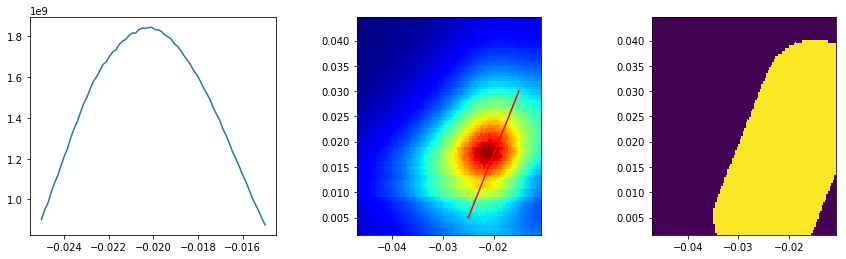

In [9]:
QY = qyr[:,:,0]
QX = qxr[:,:,0]

ind = np.sqrt((QY.ravel() - y[:,None])**2 + (QX.ravel() - x[:,None])**2) < (1e-2) #min along column
Icut = ((roi.sum(axis=2).ravel() * np.ones(ind.shape[0])[:,None]) * ind).sum(1)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))

ax1.plot(x, Icut)

ax2.pcolormesh(QX,QY,roi.sum(axis=2),cmap='jet')
ax2.set_aspect('equal')
ax2.plot(x,y,'red')

ax3.pcolormesh(QX,QY,ind.max(0).reshape(QX.shape))
ax3.set_aspect('equal')

plt.show()

### Interactivity 

In [35]:
class LineProjection(object):
    def __init__(self, img, ax, proj='xy'):
        self.proj = proj
        self.img = img
        self.q1 = img._coordinates[:,:,0]
        self.q2 = img._coordinates[:,:,1]
        self.data = np.array(img.get_array()).reshape(img._meshHeight,img._meshWidth)
        self.cidclick = img.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidrelease = img.figure.canvas.mpl_connect('button_release_event', self.on_release)
        self.ax = ax
        
    def on_press(self,event):
        self.press = event.xdata, event.ydata    
        if event.inaxes != self.img.axes: return
        
    def on_release(self,event):
        global x, y, z, area, Icut, Icut_xy, Icut_xz
        
        start_q1, start_q2 = self.press
        end_q1, end_q2 = event.xdata, event.ydata
        
        # Make array of qx, qy values along line        
        x = np.linspace(start_q1,end_q1,50) 
        y = np.linspace(start_q2,end_q2,50)
        
        # Calc
        ind = np.sqrt((self.q2[:-1,:-1].ravel() - y[:,None])**2 + (self.q1[:-1,:-1].ravel() - x[:,None])**2) < (1e-2) #min along column
        Icut = ((self.data.ravel() * np.ones(ind.shape[0])[:,None]) * ind).sum(1)
        
        # Plotting
        if len(self.img.axes.lines) == 0:
            self.img.axes.plot([start_q1, end_q1], [start_q2, end_q2])
        else:
            self.img.axes.lines[0].set_data([start_q1, end_q1], [start_q2, end_q2])
        self.img.figure.canvas.draw_idle()
            
        # Show integrated area
        if len(self.ax[2].lines) == 0: # first drawing
            area = ax[1].pcolormesh(self.q1,self.q2,ind.max(0).reshape(self.data.shape))
            ax[1].set_aspect('equal')
        else:
            area.set_array(ind.max(0))
            
        # Draw Lines
        if len(self.ax[2].lines) == 0:
            self.ax[2].plot(x,Icut)
        else:
            self.ax[2].lines[0].set_data(x,Icut)
        self.ax[2].figure.canvas.draw_idle()

        if len(self.ax[3].lines) == 0:
            self.ax[3].plot(y,Icut)
        else:
            self.ax[3].lines[0].set_data(y,Icut)
        self.ax[3].figure.canvas.draw_idle()
        
        # Output vals
        if self.proj == 'xy':
            self.x = x
            self.y = y
            Icut_xy = Icut
            self.Icut_xy = Icut_xy
        elif self.proj == 'xz':
            self.x = x
            z = y
            self.z = z
            Icut_xz = Icut
            self.Icut_xz = Icut_xz

In [38]:
%matplotlib qt5

pr = 'xy'
fig, ax = plt.subplots(1,4,figsize=(15,3))

if pr == 'xz':
    QX = qxr[:,0,:]
    QZ = qzr[:,0,:]
    i = roi.sum(1)
    
    img = ax[0].pcolormesh(QX,QZ,i,cmap='jet')
    ax[0].set_aspect('equal')
    test = LineProjection(img,ax,proj=pr)
    
elif pr == 'xy':
    QX = qxr[:,:,0]
    QY = qyr[:,:,0]
    i = roi.sum(2)

    img = ax[0].pcolormesh(QX,QY,i,cmap='jet')
    ax[0].set_aspect('equal')
    test = LineProjection(img,ax,proj=pr)

### Find the peaks in the established projections

In [44]:
import peakutils as pk
from scipy.signal import savgol_filter 

Icut_xy = savgol_filter(Icut_xy,5,0)
Icut_xz = savgol_filter(Icut_xz,5,0)

idx_xy = pk.indexes(Icut_xy)
idx_xz = pk.indexes(Icut_xz)

In [47]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4)

ax1.plot(x,Icut_xy)
ax1.scatter(x[idx_xy],Icut_xy[idx_xy],c='r')
ax1.set_xlabel('Qx')

ax2.plot(y,Icut_xy)
ax2.scatter(y[idx_xy],Icut_xy[idx_xy],c='r')
ax2.set_xlabel('Qy')

ax3.plot(x,Icut_xz)
ax3.scatter(x[idx_xz],Icut_xz[idx_xz],c='r')
ax3.set_xlabel('Qx')

ax4.plot(z,Icut_xz)
ax4.scatter(z[idx_xz],Icut_xz[idx_xz],c='r')
ax4.set_xlabel('Qz');

In [48]:
 print('Qx={0}, Qy={1}'.format(x[idx_xy],y[idx_xy]))
print('Qx={0}, Qz={1}'.format(x[idx_xz],z[idx_xz]))

Qx=[-0.02196906], Qy=[ 0.01816197]
Qx=[-0.02047985], Qz=[ 1.54236744]


See if it looks reasonable

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4))
ax1.pcolormesh(qxr[:,:,0],qyr[:,:,0],roi.sum(axis=2),cmap='jet')
ax1.set_ylabel('Qy');ax1.set_xlabel('Qx')
ax1.scatter(x[idx_xy],y[idx_xy])
ax1.set_aspect('equal')

ax2.pcolormesh(qxr[:,0,:],qzr[:,0,:],roi.sum(axis=1),cmap='jet')
ax2.set_ylabel('Qz');ax2.set_xlabel('Qx')
ax2.scatter(x[idx_xy],z[idx_xz])
ax2.set_aspect('equal')

ax3.pcolormesh(qyr[0,:,:],qzr[0,:,:],roi.sum(axis=0),cmap='jet')
ax3.set_ylabel('Qz');ax3.set_xlabel('Qy')
ax3.scatter(y[idx_xy],z[idx_xz])
ax3.set_aspect('equal')

### Make calculations with them

In [52]:
com = (x[idx_xy],y[idx_xy],z[idx_xz])